# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [37]:
#Libraries
from sklearn.datasets import  fetch_california_housing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [38]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


**Check for missing values**

In [39]:
#your code here
spaceship.isna().sum()  

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

There are multiple strategies to handle missing data

- Removing all rows or all columns containing missing data.
- Filling all missing values with a value (mean in continouos or mode in categorical for example).
- Filling all missing values with an algorithm.

For this exercise, because we have such low amount of null values, we will drop rows containing any missing value. 

In [40]:
#your code here
spaceship = spaceship.dropna()

- **Cabin** is too granular - transform it in order to obtain {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

In [41]:
#your code here
#get only the fisrt letter from all the values in the column Cabin
spaceship['Cabin'] = spaceship['Cabin'].str[0]

- Drop PassengerId and Name

In [42]:
#your code here
#drop the column Name and PassengerId
spaceship = spaceship.drop(columns=['Name', 'PassengerId'])
spaceship

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


- For non-numerical columns, do dummies.

In [43]:
#get the non numerical columns
non_numerical = spaceship.select_dtypes(include=['object'])
non_numerical

,HomePlanet,CryoSleep,Cabin,Destination,VIP
0,Europa,False,B,TRAPPIST-1e,False
1,Earth,False,F,TRAPPIST-1e,False
2,Europa,False,A,TRAPPIST-1e,True
3,Europa,False,A,TRAPPIST-1e,False
4,Earth,False,F,TRAPPIST-1e,False
...,...,...,...,...,...
8688,Europa,False,A,55 Cancri e,True
8689,Earth,True,G,PSO J318.5-22,False
8690,Earth,False,G,TRAPPIST-1e,False
8691,Europa,False,E,55 Cancri e,False


In [44]:
#your code here
#get dummies from numerical columns
spaceship_cat = pd.get_dummies(non_numerical)
spaceship_cat.shape

(6606, 18)

In [45]:
#create a for loop to transform all the values in spaceship_cat to integer
for i in spaceship_cat.columns:
    spaceship_cat[i] = spaceship_cat[i].astype(int)

In [46]:
spaceship_cat.columns

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True'],
      dtype='object')

In [47]:
#drop the columns ['Cabin', 'CryoSleep', 'Destination', 'HomePlanet', 'VIP'] from spaceship
spaceship = spaceship.drop(columns=['Cabin', 'CryoSleep', 'Destination', 'HomePlanet', 'VIP'])

In [48]:
#concatenate spaceship and spaceship_cat
spaceship = pd.concat([spaceship, spaceship_cat], axis=1)

**Perform Train Test Split**

In [49]:
#your code here
#perfom train test split
features = spaceship.drop(columns=['Transported'])
target = spaceship['Transported']

Create an instance of the normalizer

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
normalizer = MinMaxScaler()

normalizer.fit(X_train)

MinMaxScaler()

In [53]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [54]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,0.405063,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.050633,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.379747,0.00000,0.007916,0.000000,0.051276,0.000000,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.215190,0.00131,0.000000,0.046111,0.016378,0.000049,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.329114,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [55]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,0.632911,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.227848,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.189873,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.658228,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.784810,0.0,0.054775,0.0,0.07774,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [56]:
n_samples = X_train_norm.shape[0]
print(f'Number of samples in the training data: {n_samples}')


Number of samples in the training data: 5284


In [57]:
# Set the max_samples parameter to a value less than or equal to the number of samples
max_samples = min(10000, n_samples)

In [32]:
bagging_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples=max_samples,
)

Training Bagging model with our normalized data

In [58]:
# Fit the BaggingRegressor
bagging_reg.fit(X_train_norm, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20), max_samples=100)

In [61]:
pred = bagging_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", bagging_reg.score(X_test_norm, y_test))

MAE 0.3189485627836611
RMSE 0.40320904508621125
R2 score 0.34968986384266265


# Random Forests

- Initialize a Random Forest

In [59]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)

- Training the model

In [60]:
forest.fit(X_train_norm, y_train)

RandomForestRegressor(max_depth=20)

In [62]:
pred = forest.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", forest.score(X_test_norm, y_test))

MAE 0.2676301994861472
RMSE 0.38233511582563634
R2 score 0.415279436826389


# Gradient Boosting

Now, each estimator will predict the error caused by its predecessor.

- Initialize a AdaBoost model

In [63]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)

- Training the model

In [64]:
gb_reg.fit(X_train_norm, y_train)

GradientBoostingRegressor(max_depth=20)

- Evaluate the model

In [65]:
pred = gb_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", gb_reg.score(X_test_norm, y_test))

MAE 0.2607666219411704
RMSE 0.41776559365657684
R2 score 0.3018876350270716


- Adaptive Boosting

- Initialize a AdaBoost model

In [66]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)

- Training the model

In [67]:
ada_reg.fit(X_train_norm, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100)

- Evaluate the model

In [69]:
pred = ada_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", ada_reg.score(X_test_norm, y_test))

MAE 0.24341638535944124
RMSE 0.4237995735177293
R2 score 0.2815756859447631


Which model is the best and why?

In [70]:
# Initialize models
n_samples = X_train_norm.shape[0]
max_samples = min(10000, n_samples)

models = {
    'Bagging Regressor': BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),
                                          n_estimators=100,
                                          max_samples=max_samples),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20),
    'Gradient Boosting': GradientBoostingRegressor(max_depth=20, n_estimators=100),
    'AdaBoost': AdaBoostRegressor(DecisionTreeRegressor(max_depth=20), n_estimators=100)
}

# Evaluate models
results = {}

for model_name, model in models.items():
    model.fit(X_train_norm, y_train)
    pred = model.predict(X_test_norm)
    
    mae = mean_absolute_error(pred, y_test)
    rmse = mean_squared_error(pred, y_test, squared=False)
    r2 = model.score(X_test_norm, y_test)
    
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2
    }

# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MAE: {metrics['MAE']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"R2 Score: {metrics['R2 Score']}\n")

/home/danicoco/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: Bagging Regressor
MAE: 0.27030071840476266
RMSE: 0.3856658945822121
R2 Score: 0.4050472710244082

Model: Random Forest
MAE: 0.2699816380179639
RMSE: 0.38468260882905275
R2 Score: 0.4080771618578959

Model: Gradient Boosting
MAE: 0.26147361528924273
RMSE: 0.4184750084707597
R2 Score: 0.2995146691415904

Model: AdaBoost
MAE: 0.24108155621408253
RMSE: 0.4240825307378778
R2 Score: 0.28061602849182765



Based on the evaluation metrics, the Random Forest model performs the best among the four models tested. Here are the reasons:

Lowest MAE (Mean Absolute Error): Random Forest has an MAE of 0.2699816380179639, which indicates it has the smallest average error between the predicted and actual values.

Lowest RMSE (Root Mean Squared Error): Random Forest has an RMSE of 0.38468260882905275, indicating the lowest average squared difference between predicted and actual values, which shows it has better prediction accuracy.

Highest R2 Score: Random Forest has the highest R2 score of 0.4080771618578959, which indicates that it explains the highest proportion of the variance in the target variable compared to the other models.

               Model       MAE      RMSE  R2 Score
0  Bagging Regressor  0.270301  0.385669  0.405047
1      Random Forest  0.269982  0.384683  0.408077
2  Gradient Boosting  0.261474  0.418475  0.299515
3           AdaBoost  0.241082  0.424083  0.280616


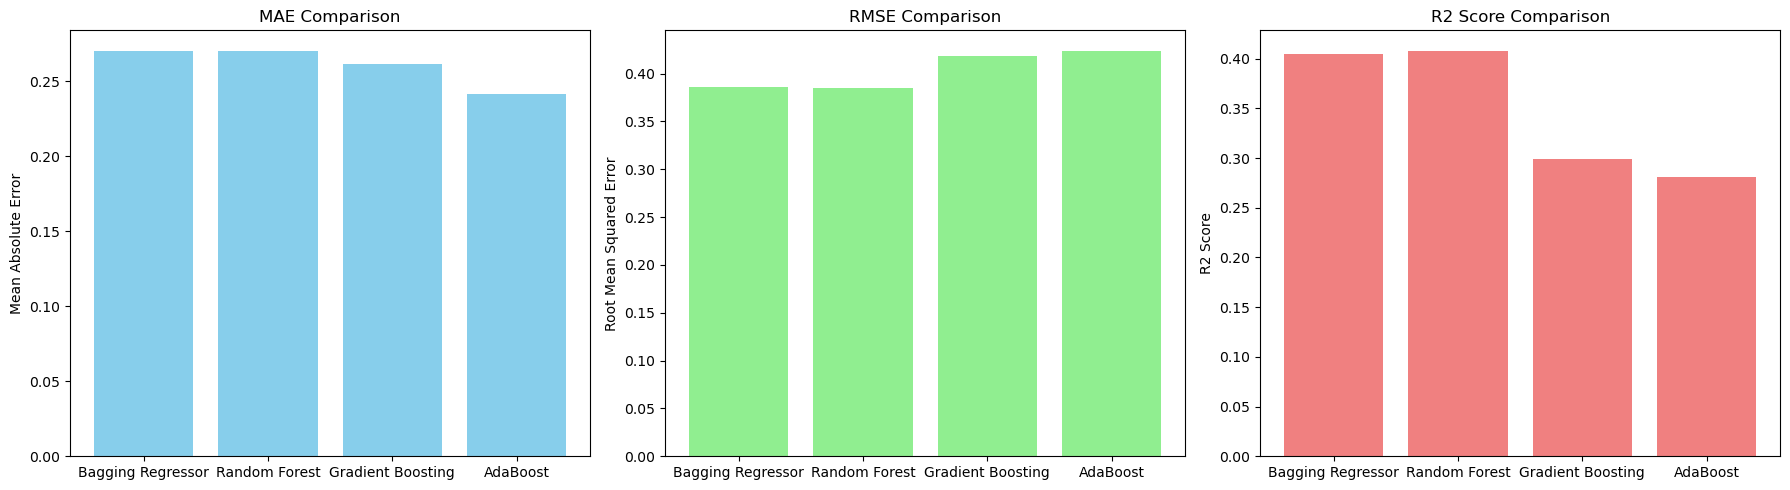

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a summary dataframe for the results
results = {
    'Model': ['Bagging Regressor', 'Random Forest', 'Gradient Boosting', 'AdaBoost'],
    'MAE': [0.27030071840476266, 0.2699816380179639, 0.26147361528924273, 0.24108155621408253],
    'RMSE': [0.385668945822121, 0.38468260882905275, 0.4184750084707597, 0.4240825307378778],
    'R2 Score': [0.4050472710244082, 0.4080771618578959, 0.2995146691415904, 0.28061602849182765]
}

results_df = pd.DataFrame(results)

# Display the summary table
print(results_df)

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot MAE
ax[0].bar(results_df['Model'], results_df['MAE'], color='skyblue')
ax[0].set_title('MAE Comparison')
ax[0].set_ylabel('Mean Absolute Error')

# Plot RMSE
ax[1].bar(results_df['Model'], results_df['RMSE'], color='lightgreen')
ax[1].set_title('RMSE Comparison')
ax[1].set_ylabel('Root Mean Squared Error')

# Plot R2 Score
ax[2].bar(results_df['Model'], results_df['R2 Score'], color='lightcoral')
ax[2].set_title('R2 Score Comparison')
ax[2].set_ylabel('R2 Score')

# Display the plots
plt.tight_layout()
plt.show()
